In [2]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment
import noisereduce as nr
import logging


C:\Users\naufa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('data/songs_wav.csv')

df.head()

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,160,https://www.youtube.com/watch?v=RjI7W_XmzLM,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
1,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,243,https://www.youtube.com/watch?v=lAVi2OE2bRY,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
2,Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,210,https://www.youtube.com/watch?v=W3PRdCxocM0,datasets/songs/tari_bungong_jeumpa_aceh_rumah_...,datasets/wav_songs/tari_bungong_jeumpa_aceh_ru...
3,KAKA ALFARISI - BUNGONG JEUMPA (OFFICIAL VIDEO),Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,261,https://www.youtube.com/watch?v=N9JDR0ZH4AU,datasets/songs/kaka_alfarisi_bungong_jeumpa_of...,datasets/wav_songs/kaka_alfarisi_bungong_jeump...
4,"TARI ""BUNGONG JEUMPA"" BERASAL DARI ACEH",Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,215,https://www.youtube.com/watch?v=3iToqU4LnPU,datasets/songs/tari_bungong_jeumpa_berasal_dar...,datasets/wav_songs/tari_bungong_jeumpa_berasal...


In [ ]:
def get_duration(file_path):
    if pd.isna(file_path):  # Menangani NaN atau None
        print('Skipping: file path is NaN or None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    
    logging.info(f'sample rate: {sr}, duration: {duration}')
    
    return sr, duration

In [5]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))


sample rate: 22050, duration: 159.79972789115646
sample rate: 22050, duration: 242.13768707482993
sample rate: 22050, duration: 209.62975056689342
sample rate: 22050, duration: 260.92263038548754
sample rate: 22050, duration: 214.7613605442177
sample rate: 22050, duration: 253.60834467120182
sample rate: 22050, duration: 258.007074829932
sample rate: 22050, duration: 166.81215419501135
sample rate: 22050, duration: 257.5092970521542
sample rate: 22050, duration: 190.49650793650792
sample rate: 22050, duration: 148.21297052154196
sample rate: 22050, duration: 254.44426303854874
sample rate: 22050, duration: 248.59283446712018
sample rate: 22050, duration: 136.2314739229025
sample rate: 22050, duration: 147.98077097505669
sample rate: 22050, duration: 179.67600907029478
sample rate: 22050, duration: 153.83219954648527
sample rate: 22050, duration: 151.3012244897959
sample rate: 22050, duration: 261.3173696145125
sample rate: 22050, duration: 282.6100680272109
sample rate: 22050, duration

In [6]:
df.describe()

,duration,sample_rate,duration_sec
count,136.000000,136.0,136.000000
mean,218.433824,22050.0,217.504570
std,59.846062,0.0,60.168124
min,37.000000,22050.0,36.455329
25%,174.750000,22050.0,173.122177
50%,229.000000,22050.0,228.252154
75%,268.000000,22050.0,271.487710
max,299.000000,22050.0,298.399637


In [7]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        title = row['title']
        region = row['region']
        keyword = row['keyword']
        nama_lagu = row['nama_lagu']
        
        # Cek jika wav_path adalah string dan file yang valid
        if isinstance(wav_path, str) and os.path.isfile(wav_path):
            norm_title = normalized_yt_title(nama_lagu)
            norm_region = region.lower().replace(' ', '_')
            output_dir = os.path.join(output_base_folder, norm_region, norm_title + "_" + str(index))
            
            audio = AudioSegment.from_wav(wav_path)
            total_duration = len(audio) / 1000  # Durasi dalam detik
            segment_duration = 30
            num_segments = int(total_duration // segment_duration)


            os.makedirs(output_dir, exist_ok=True)

            for i in range(num_segments):
                start_time = i * segment_duration * 1000
                end_time = (i + 1) * segment_duration * 1000
                segment = audio[start_time:end_time]
                
                segment_file = os.path.join(output_dir, f"segment{i + 1}.wav")
                segment.export(segment_file, format="wav")
                
                split_result.append({
                    'title': nama_lagu,
                    'region': region,
                    'keyword': keyword,
                    '30s_path': segment_file
                })
            print(f"Saved {num_segments} segments in {norm_region} for {title} at: {output_dir}")
        else:
            print(f"Invalid wav_path at index {index}: {wav_path}")


In [8]:
split_songs_to_segments(df)

Saved 5 segments in aceh for Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh) at: datasets/30s_segments\aceh\bungong_jeumpa_0
Saved 8 segments in aceh for Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita at: datasets/30s_segments\aceh\bungong_jeumpa_1
Saved 6 segments in aceh for Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya at: datasets/30s_segments\aceh\bungong_jeumpa_2
Saved 8 segments in aceh for KAKA ALFARISI - BUNGONG JEUMPA (OFFICIAL VIDEO) at: datasets/30s_segments\aceh\bungong_jeumpa_3
Saved 7 segments in aceh for TARI "BUNGONG JEUMPA" BERASAL DARI ACEH at: datasets/30s_segments\aceh\bungong_jeumpa_4
Saved 8 segments in aceh for Jambo - Safira Amalia (Official Music Video) at: datasets/30s_segments\aceh\jambo_jambo_5
Saved 8 segments in aceh for Jambo at: datasets/30s_segments\aceh\jambo_jambo_6
Saved 5 segments in aceh for Lagu daerah Aceh - Jambo Jambo at: datasets/30s_segments\aceh\jambo_jambo_7
Saved 8 segments in aceh for TARIAN ACEH JAMBO 

In [9]:
df_res = pd.DataFrame(split_result)
df_res.head()

,title,region,keyword,30s_path
0,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
1,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
2,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
3,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
4,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...


### Feature Extraction

In [10]:
def extract_mfcc_features(wav_path, n_mfcc=13):
    y, sr = librosa.load(wav_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

def extract_spectogram_features(wav_path):
    y, sr = librosa.load(wav_path)
    S = np.abs(librosa.stft(y))
    S_mean = np.mean(S.T, axis=0)
    return S_mean

def extract_features(wav_path):
    mfcc = extract_mfcc_features(wav_path)
    spectogram = extract_spectogram_features(wav_path)
    combined_features = np.concatenate((mfcc, spectogram))
    return combined_features

In [153]:
# df_res['mfcc_features'] = df_res['30s_path'].apply(extract_mfcc_features)
# df_res['spectogram_features'] = df_res['30s_path'].apply(extract_spectogram_features)
# df_res.head()

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

### RANDOM FOREST

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
X = []
y = []

for index, row in df_res.iterrows():
    wav_path = row['30s_path']
    label = row['title']
    
    features = extract_features(wav_path)
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [13]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (913, 1038), y shape: (913,)


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.73%
F1 Score: 99.72%
Precision Score: 99.75%
Recall Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        27
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        35
              Aneuk Yatim       1.00      1.00      1.00        35
           Bungong Jeumpa       1.00      1.00      1.00        29
            Dayung Sampan       1.00      1.00      1.00        23
                 Dewa Ayu       1.00      1.00      1.00        15
                      Ibo       1.00      1.00      1.00        20
        Icak-Icak Dek Tau       1.00      1.00      1.00        28
            Jambo – Jambo       1.00      1.00      1.00        26
            Jereh Bu Guru       1.00      1.00      1.00        24
               Jibeak Weo       1.00      1.00      1.00        24
Lagu Men Sahang Lah Mirah

In [16]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 86.34%
F1 Score: 86.46%
Precision Score: 88.30%
Recall Score: 86.34%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.40      0.40      0.40         5
 Alam Wisata Pulau Bangka       1.00      1.00      1.00         9
              Aneuk Yatim       0.60      1.00      0.75         3
           Bungong Jeumpa       0.83      1.00      0.91         5
            Dayung Sampan       0.64      1.00      0.78         9
                 Dewa Ayu       0.67      1.00      0.80         2
                      Ibo       1.00      0.75      0.86         4
        Icak-Icak Dek Tau       0.86      1.00      0.92         6
            Jambo – Jambo       1.00      1.00      1.00         9
            Jereh Bu Guru       1.00      0.88      0.93         8
               Jibeak Weo       1.00      0.91      0.95        11
Lagu Men Sahang Lah Mirah 

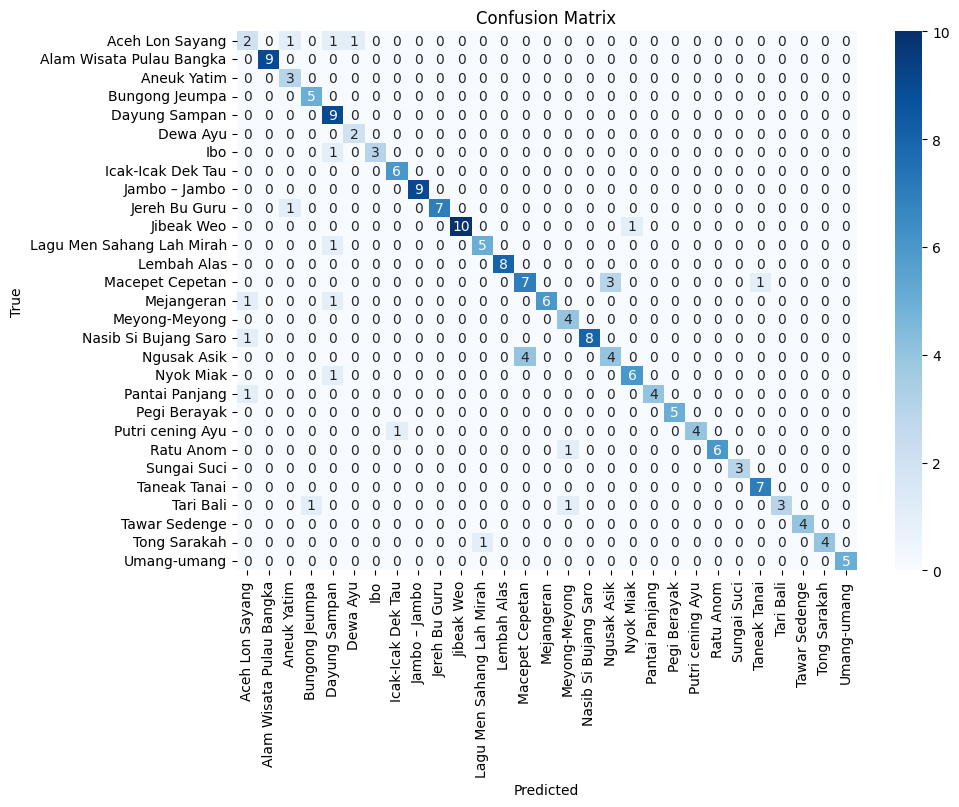

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [18]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=7.5)
svm_model.fit(X_train, y_train)


SVC(C=7.5, kernel='linear', random_state=42)

In [19]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.73%
F1 Score: 99.72%
Precision Score: 99.75%
Recall Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        27
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        35
              Aneuk Yatim       1.00      1.00      1.00        35
           Bungong Jeumpa       1.00      1.00      1.00        29
            Dayung Sampan       1.00      1.00      1.00        23
                 Dewa Ayu       1.00      1.00      1.00        15
                      Ibo       1.00      1.00      1.00        20
        Icak-Icak Dek Tau       1.00      1.00      1.00        28
            Jambo – Jambo       1.00      1.00      1.00        26
            Jereh Bu Guru       1.00      1.00      1.00        24
               Jibeak Weo       1.00      1.00      1.00        24
Lagu Men Sahang Lah Mirah

In [20]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 87.98%
F1 Score: 87.81%
Precision Score: 88.44%
Recall Score: 87.98%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.50      0.60      0.55         5
 Alam Wisata Pulau Bangka       1.00      1.00      1.00         9
              Aneuk Yatim       1.00      1.00      1.00         3
           Bungong Jeumpa       0.71      1.00      0.83         5
            Dayung Sampan       1.00      1.00      1.00         9
                 Dewa Ayu       0.67      1.00      0.80         2
                      Ibo       1.00      0.75      0.86         4
        Icak-Icak Dek Tau       1.00      1.00      1.00         6
            Jambo – Jambo       0.90      1.00      0.95         9
            Jereh Bu Guru       1.00      0.88      0.93         8
               Jibeak Weo       1.00      1.00      1.00        11
Lagu Men Sahang Lah Mirah 

### Decision Tree's

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.73%
F1 Score: 99.72%
Precision Score: 99.75%
Recall Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        27
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        35
              Aneuk Yatim       1.00      1.00      1.00        35
           Bungong Jeumpa       1.00      1.00      1.00        29
            Dayung Sampan       1.00      1.00      1.00        23
                 Dewa Ayu       1.00      1.00      1.00        15
                      Ibo       1.00      1.00      1.00        20
        Icak-Icak Dek Tau       1.00      1.00      1.00        28
            Jambo – Jambo       1.00      1.00      1.00        26
            Jereh Bu Guru       1.00      1.00      1.00        24
               Jibeak Weo       1.00      1.00      1.00        24
Lagu Men Sahang Lah Mirah

In [23]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 60.66%
F1 Score: 60.22%
Precision Score: 64.88%
Recall Score: 60.66%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.17      0.20      0.18         5
 Alam Wisata Pulau Bangka       0.67      0.67      0.67         9
              Aneuk Yatim       0.43      1.00      0.60         3
           Bungong Jeumpa       0.57      0.80      0.67         5
            Dayung Sampan       0.89      0.89      0.89         9
                 Dewa Ayu       0.50      1.00      0.67         2
                      Ibo       1.00      0.75      0.86         4
        Icak-Icak Dek Tau       0.67      0.67      0.67         6
            Jambo – Jambo       0.45      0.56      0.50         9
            Jereh Bu Guru       0.50      0.62      0.56         8
               Jibeak Weo       0.86      0.55      0.67        11
Lagu Men Sahang Lah Mirah 